In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np

# Charger le fichier CSV
df = pd.read_csv("/home/onyxia/work/Statapp_Valuco/ValueCo data extract - ENSAE research project.csv")

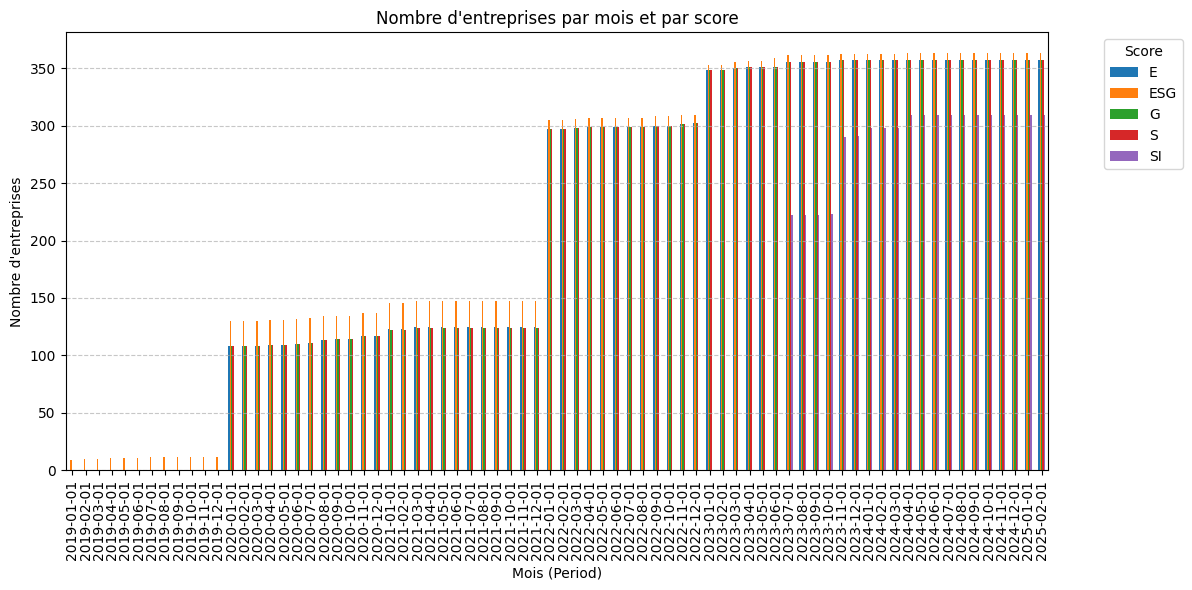

In [3]:
resultat = (
    df.groupby(['score_kind', 'period'])
    .agg(nombre_entreprises=('name', 'nunique'))
    .reset_index()
)

# 3. Pivoter pour avoir les scores en colonnes (si plusieurs scores)
resultat_pivot = resultat.pivot(
    index='period', 
    columns='score_kind', 
    values='nombre_entreprises'
)

# 4. Créer un diagramme en barres empilées (ou groupées)
resultat_pivot.plot(kind='bar', stacked=False, figsize=(12, 6))

# 5. Personnalisation du graphique
plt.title("Nombre d'entreprises par mois et par score")
plt.xlabel("Mois (Period)")
plt.ylabel("Nombre d'entreprises")
plt.legend(title='Score', bbox_to_anchor=(1.05, 1))  # Légende à droite
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ajuster les marges

# 6. Afficher et sauvegarder

plt.show()

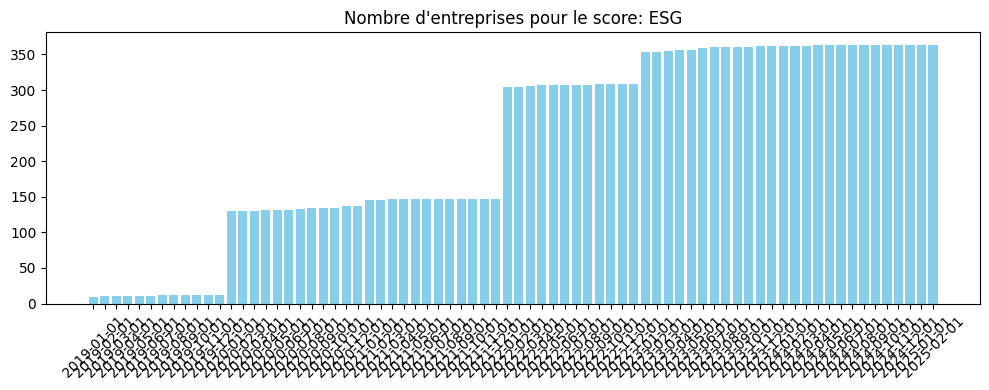

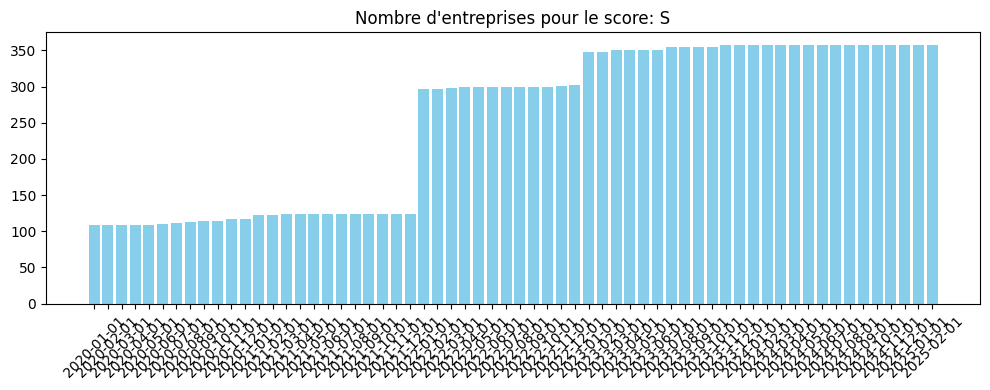

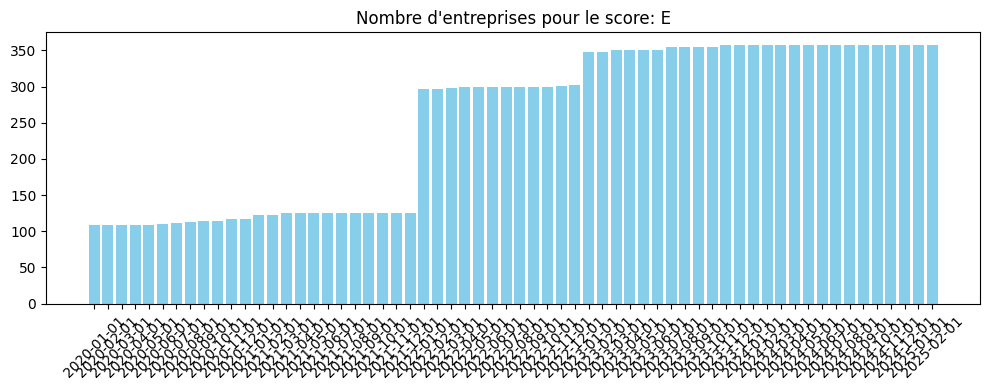

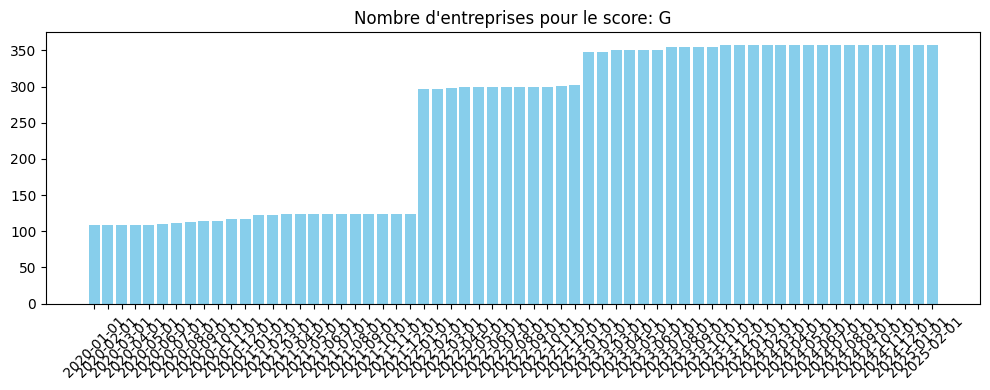

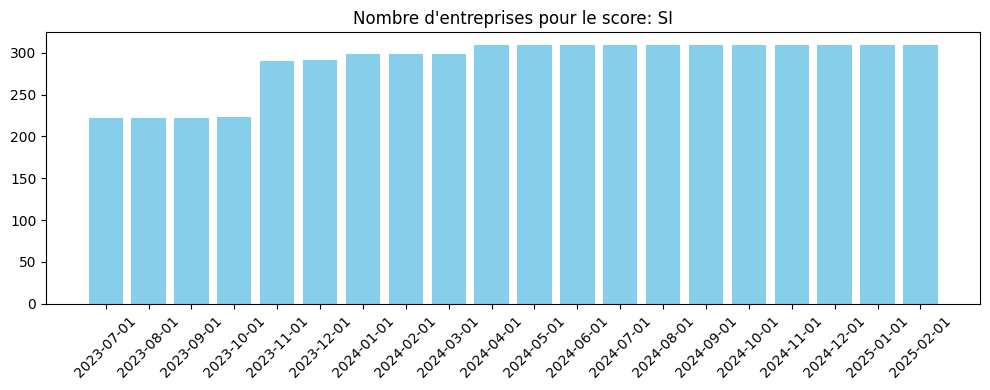

In [5]:
scores = df['score_kind'].unique()

# Boucle pour générer un graphique par score
for score in scores:
    df_score = df[df['score_kind'] == score]
    resultat = df_score.groupby('period').agg(nombre_entreprises=('name', 'nunique')).reset_index()
    
    plt.figure(figsize=(10, 4))
    plt.bar(resultat['period'], resultat['nombre_entreprises'], color='skyblue')
    plt.title(f"Nombre d'entreprises pour le score: {score}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [34]:
def calculer_persistance_entreprise(df, entreprise, score_cible):
    """ Vérifie si une entreprise a conservé le score cible chaque mois depuis sa première apparition """
    df_ent = df[df['name'] == entreprise].copy()
    df_ent['period'] = pd.to_datetime(df_ent['period'])
    df_ent['mois'] = df_ent['period'].dt.to_period('M')
    df_ent = df_ent.sort_values('period')

    # Mois où l'entreprise a eu le score cible
    mois_score = df_ent[df_ent['score_kind'] == score_cible]['mois'].unique()
    if len(mois_score) == 0:
        return False

    premiere_mois = mois_score.min()
    derniere_mois = df_ent['mois'].max()

    # Mois attendus : tous les mois calendaires à partir de la première apparition du score
    mois_attendus = pd.period_range(start=premiere_mois, end=derniere_mois, freq='M')

    for mois in mois_attendus:
        df_mois = df_ent[df_ent['mois'] == mois]
        # Si l'entreprise n'est pas présente ce mois → pas persistante
        if df_mois.empty:
            return False

        # Si l'entreprise est là mais n'a pas le score cible → pas persistante
        if score_cible not in df_mois['score_kind'].values:
            return False

    return True

def generer_tableau_persistance(df):
    """ Génère un tableau Score / % d'entreprises persistantes selon la logique mensuelle """
    scores = df['score_kind'].unique()
    resultats = {}

    for score in scores:
        # On récupère les entreprises qui ont eu AU MOINS UNE FOIS ce score
        entreprises = df[df['score_kind'] == score]['name'].unique()
        if len(entreprises) == 0:
            resultats[score] = 0.0
            continue

        # On compte combien d'entreprises sont persistantes pour ce score
        persistantes = sum(
            calculer_persistance_entreprise(df, entreprise, score)
            for entreprise in entreprises
        )

        resultats[score] = round((persistantes / len(entreprises)) * 100, 2)

    # Création du DataFrame de résultats trié
    tableau = pd.DataFrame({
        'Score': resultats.keys(),
        '% Persistance': resultats.values()
    }).sort_values('% Persistance', ascending=False)

    return tableau

generer_tableau_persistance(df)

def export_tableau_matplotlib(df_resultat, nom_fichier='tableau_persistance.png'):
    """ Version utilisant matplotlib """
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('off')
    
    # Création du tableau
    table = plt.table(cellText=df_resultat.values,
                     colLabels=df_resultat.columns,
                     loc='center',
                     cellLoc='center')
    
    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    
    # Couleurs alternées
    for k, cell in table._cells.items():
        if k[0] == 0:  # Header
            cell.set_facecolor('#40466e')
            cell.set_text_props(color='white')
        elif k[0] % 2 == 1:  # Lignes impaires
            cell.set_facecolor('#f1f1f1')
    
    plt.savefig(nom_fichier, bbox_inches='tight', dpi=120)
    plt.close()
    print(f"Tableau exporté sous {nom_fichier}")

# Utilisation
export_tableau_matplotlib(tableau_persistance)

Tableau exporté sous tableau_persistance.png


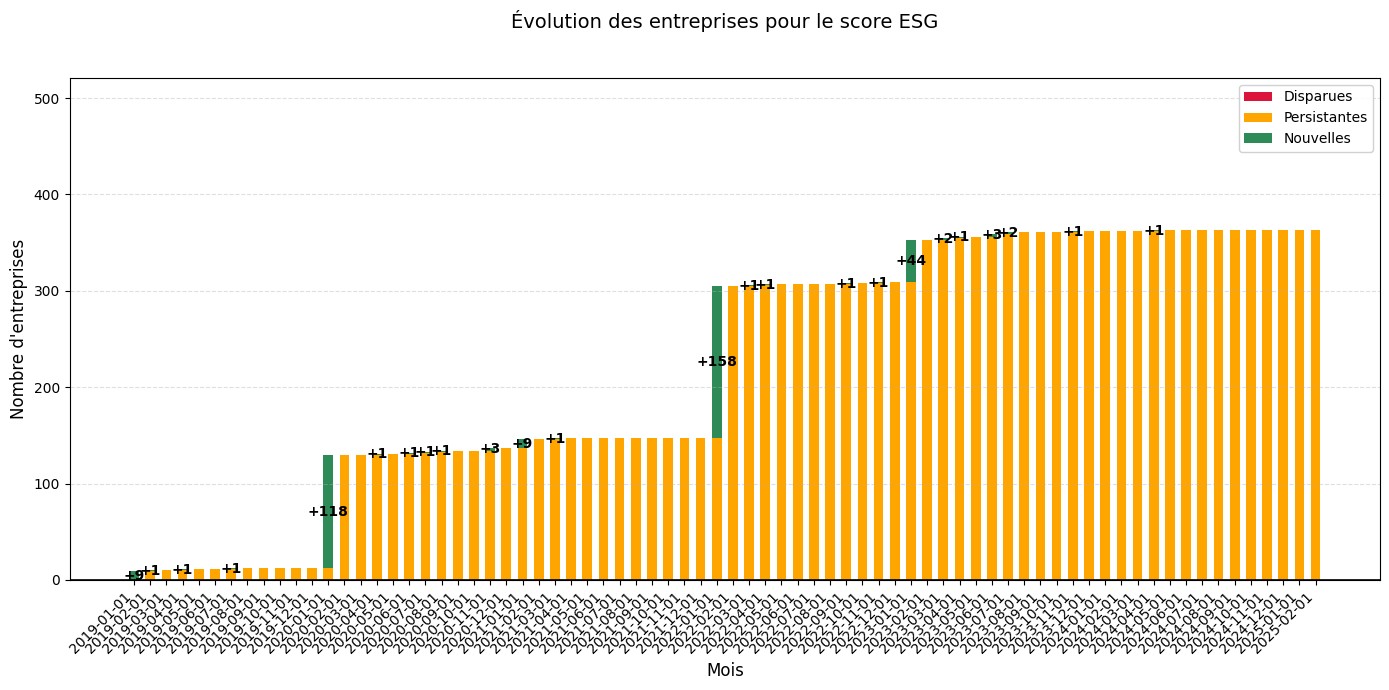

In [32]:


def histogramme_evolution_score(df, score_cible):
    """
    Crée un histogramme empilé verticalement avec:
    - Partie négative agrandie (disparitions)
    - Pas d'étiquette sur la partie persistante
    - Échelle adaptée pour mieux voir les variations
    """
    # Filtrer pour le score cible et trier par période
    df_score = df[df['score_kind'] == score_cible].sort_values('period')
    periods = sorted(df_score['period'].unique())
    
    if not periods:
        print(f"Aucune donnée pour le score {score_cible}")
        return
    
    # Dictionnaires pour stocker les résultats
    nouvelles = {}
    persistantes = {}
    disparues = {}
    
    # Premier mois (toutes nouvelles)
    prev_entreprises = set(df_score[df_score['period'] == periods[0]]['name'])
    nouvelles[periods[0]] = len(prev_entreprises)
    persistantes[periods[0]] = 0
    disparues[periods[0]] = 0
    
    # Analyse mois par mois
    for i in range(1, len(periods)):
        curr_period = periods[i]
        prev_period = periods[i-1]
        
        curr_entreprises = set(df_score[df_score['period'] == curr_period]['name'])
        
        nouvelles[curr_period] = len(curr_entreprises - prev_entreprises)
        persistantes[curr_period] = len(curr_entreprises & prev_entreprises)
        disparues[curr_period] = -len(prev_entreprises - curr_entreprises)  # Négatif
        
        prev_entreprises = curr_entreprises
    
    # Préparation des données
    periods_str = [str(p) for p in periods]
    width = 0.6
    
    # Création du graphique avec échelle adaptée
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # 1. Barres disparues (négatif) - en premier pour l'échelle
    bar_disparues = ax.bar(periods_str, disparues.values(), 
                          width, color='#DC143C', label='Disparues')
    
    # 2. Barres persistantes (base)
    bar_persist = ax.bar(periods_str, persistantes.values(), 
                        width, color='#FFA500', label='Persistantes',
                        bottom=[0]*len(periods))  # Commence à y=0
    
    # 3. Barres nouvelles (positif)
    bar_nouvelles = ax.bar(periods_str, nouvelles.values(), 
                          width, color='#2E8B57', label='Nouvelles',
                          bottom=persistantes.values())
    
    # Personnalisation avancée
    ax.set_title(f'Évolution des entreprises pour le score {score_cible}\n', pad=20, fontsize=14)
    ax.set_xlabel('Mois', fontsize=12)
    ax.set_ylabel('Nombre d\'entreprises', fontsize=12)
    ax.axhline(0, color='black', linewidth=1.2)
    
    # Ajustement spécial de l'échelle y pour agrandir le négatif
    y_max = max(nouvelles.values()) + max(persistantes.values())
    y_min = min(disparues.values()) * 1.3  # 30% plus d'espace en négatif
    ax.set_ylim(y_min, y_max)
    
    # Légende améliorée
    ax.legend(loc='upper right', framealpha=0.9)
    
    # Affichage des valeurs uniquement sur nouvelles et disparues
    for i, (n, d) in enumerate(zip(nouvelles.values(), disparues.values())):
        if n > 0:
            ax.text(i, persistantes[periods[i]] + n/2, f'+{n}', 
                   ha='center', va='center', fontweight='bold')
        if d < 0:
            ax.text(i, d/2, f'{-d}', 
                   ha='center', va='center', fontweight='bold', color='white')
    
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
histogramme_evolution_score(df, 'ESG')

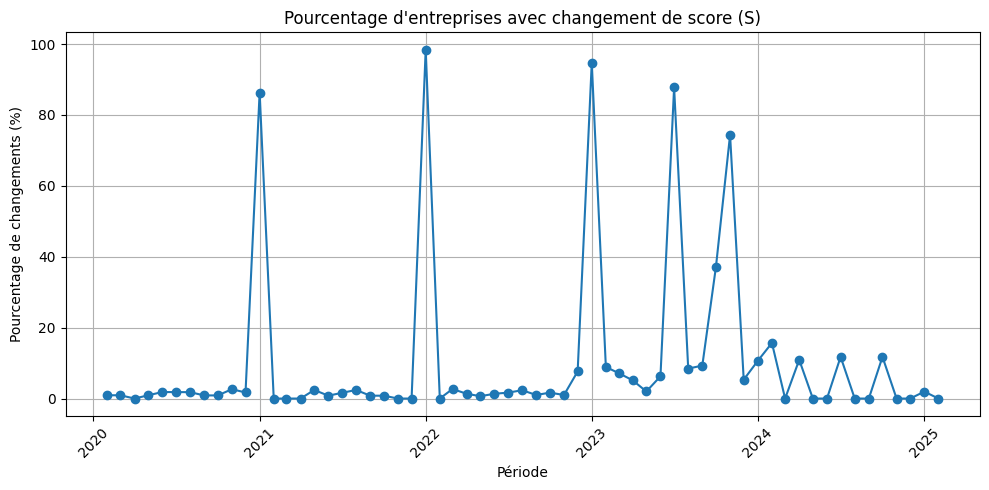

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier CSV
df = pd.read_csv("/home/onyxia/work/Statapp_Valuco/ValueCo data extract - ENSAE research project.csv", parse_dates=["period"])

# Choisir le type de score voulu
score_type = "S"  # à remplacer par le score_kind de votre choix
df = df[df["score_kind"] == score_type]

# Trier les données par entreprise et période
df = df.sort_values(by=["name", "period"])

# Calculer la différence de consensus mois par mois pour chaque entreprise
df["prev_consensus"] = df.groupby("name")["consensus"].shift(1)
df["has_changed"] = df["consensus"] != df["prev_consensus"]

# Retirer les premiers mois pour chaque entreprise (on ne compte pas encore)
df["first_period"] = df.groupby("name")["period"].transform("min")
df = df[df["period"] > df["first_period"]]

# Calculer le pourcentage de changement par période
summary = df.groupby("period").agg(
    total=("name", "nunique"),
    changed=("has_changed", "sum")
).reset_index()
summary["percentage_changed"] = (summary["changed"] / summary["total"]) * 100

# Tracer le graphique
plt.figure(figsize=(10, 5))
plt.plot(summary["period"], summary["percentage_changed"], marker="o", linestyle='-')
plt.title(f"Pourcentage d'entreprises avec changement de score ({score_type})")
plt.xlabel("Période")
plt.ylabel("Pourcentage de changements (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

# Vérifier l'installation
try:
    import openpyxl
    print("openpyxl version :", openpyxl.__version__)
except ImportError:
    print("openpyxl n'est pas installé")

# Lire le fichier Excel
file_path = "/home/onyxia/work/Statapp_Valuco/ValueCo V2.xlsx"

# Méthode 1: Lire toutes les feuilles en dictionnaire
all_sheets = pd.read_excel(file_path, sheet_name=None, engine='openpyxl')

for sheet_name, df in all_sheets.items():
    print(f"\n● Feuille : {sheet_name}")
    print("Colonnes :", df.columns.tolist())
    print("Aperçu :")
    print(df.head(2))

# Méthode 2: Alternative avec ExcelFile
with pd.ExcelFile(file_path, engine='openpyxl') as excel:
    print("\nNoms des feuilles :", excel.sheet_names)
    
    for sheet_name in excel.sheet_names:
        df = pd.read_excel(excel, sheet_name=sheet_name)
        print(f"\nFeuille '{sheet_name}' - {len(df.columns)} colonnes")
        print(df.columns.tolist())

In [42]:
import pandas as pd
from pathlib import Path
import time

def split_excel_sheets(input_file, output_folder="feuilles_separees"):
    """Sépare chaque feuille d'un fichier Excel en fichiers individuels."""
    
    # Créer le dossier de sortie s'il n'existe pas
    output_path = Path(output_folder)
    output_path.mkdir(exist_ok=True)
    
    # Nom du fichier source (sans extension)
    source_name = Path(input_file).stem
    
    try:
        # Lire toutes les feuilles
        with pd.ExcelFile(input_file) as excel:
            print(f"\nFichier source : {source_name}")
            print(f"Feuilles détectées : {excel.sheet_names}")
            
            for sheet_name in excel.sheet_names:
                # Lire la feuille
                df = pd.read_excel(excel, sheet_name=sheet_name)
                
                # Nom du fichier de sortie
                output_file = output_path / f"{source_name}_{sheet_name}.xlsx"
                
                # Enregistrement
                df.to_excel(output_file, index=False, sheet_name=sheet_name[:31])  # Limite de 31 caractères
                print(f"✓ Feuille '{sheet_name}' sauvegardée ({len(df)} lignes)")
                
                # Vérification (optionnel)
                test_df = pd.read_excel(output_file)
                assert not test_df.empty, "Erreur: fichier vide"
                
    except Exception as e:
        print(f"\n⚠️ Erreur critique : {str(e)}")
        return False
    
    print("\nOpération terminée avec succès!")
    return True

# Utilisation
input_excel = "/home/onyxia/work/Statapp_Valuco/ValueCo V2.xlsx"  # Remplacez par votre chemin
split_excel_sheets(input_excel)



Fichier source : ValueCo V2
Feuilles détectées : ['VALUECO', 'ESG2021', 'ESG2022', 'ESG2023', 'ESG2024']
✓ Feuille 'VALUECO' sauvegardée (369 lignes)
✓ Feuille 'ESG2021' sauvegardée (173383 lignes)
✓ Feuille 'ESG2022' sauvegardée (180088 lignes)
✓ Feuille 'ESG2023' sauvegardée (188414 lignes)
✓ Feuille 'ESG2024' sauvegardée (186989 lignes)

Opération terminée avec succès!


True

In [46]:
df = pd.read_excel("/home/onyxia/work/Statapp_Valuco/feuilles_separees/ValueCo V2_ESG2021.xlsx")  # remplacez par le nom réel

# Afficher les 5 premières lignes
print(df.head())

    ISSUER_ISIN  AS_OF_DATE IVA_RATING_DATE IVA_COMPANY_RATING  \
0  US17243V1026    20210101      2020-07-23                BBB   
1  US79546E1047    20210101      2020-03-24                BBB   
2  US1264081035    20210101      2020-07-23                  A   
3  US1270971039    20210101      2020-04-24                  B   
4  US1265011056    20210101      2020-04-24                  A   

  IVA_PREVIOUS_RATING  IVA_RATING_TREND  INDUSTRY_ADJUSTED_SCORE  \
0                   A              -1.0                      5.3   
1                 BBB               0.0                      4.5   
2                   A               0.0                      6.8   
3                   B               0.0                      2.8   
4                   A               0.0                      6.2   

   WEIGHTED_AVERAGE_SCORE  ENVIRONMENTAL_PILLAR_SCORE  SOCIAL_PILLAR_SCORE  \
0                     4.9                         8.3                  5.5   
1                     4.3             

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Charger les données
fichier_excel = "/home/onyxia/work/Statapp_Valuco/feuilles_separees/ValueCo V2_ESG2021.xlsx"
df = pd.read_excel(fichier_excel, sheet_name=None)  # Toutes les feuilles
df_complet = pd.concat(df.values(), ignore_index=True)

# 2. Préparation des dates
df_complet['DATE'] = pd.to_datetime(df_complet['IVA_RATING_DATE'])
df_complet['MOIS'] = df_complet['DATE'].dt.to_period('M').astype(str)

# 3. Calcul des statistiques
stats = df_complet.groupby('MOIS')['WEIGHTED_AVERAGE_SCORE'].agg(
    ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
).rename(columns={'<lambda_0>': 'Q1', '<lambda_1>': 'Q3'}).reset_index()

# 4. Création du graphique
plt.figure(figsize=(14, 7))

# Courbe de la moyenne
plt.plot(stats['MOIS'], stats['mean'], 
         label='Moyenne', 
         color='#2c7bb6', 
         marker='o',
         linewidth=2.5,
         markersize=8)

# Barres d'erreur pour les quartiles
for i, mois in enumerate(stats['MOIS']):
    plt.vlines(x=i, 
               ymin=stats.loc[i, 'Q1'], 
               ymax=stats.loc[i, 'Q3'],
               color='#d7191c',
               linewidth=1.5,
               label='Q1-Q3' if i == 0 else "")

# Points pour Q1 et Q3
plt.scatter(stats['MOIS'], stats['Q1'], 
            color='#fdae61', 
            s=100, 
            label='1er Quartile',
            zorder=3)
plt.scatter(stats['MOIS'], stats['Q3'], 
            color='#abd9e9', 
            s=100, 
            label='3ème Quartile',
            zorder=3)

# Personnalisation
plt.title('Weighted Average Score par Mois\nMoyenne et Quartiles', pad=20, fontsize=14)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)

# Légende personnalisée
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Évite les doublons
plt.legend(by_label.values(), by_label.keys(), framealpha=1)

plt.tight_layout()
plt.show()

In [ ]:
fichier_excel = "/home/onyxia/work/Statapp_Valuco/feuilles_separees/ValueCo V2_ESG2022.xlsx"
df = pd.read_excel(fichier_excel, sheet_name=None)  # Toutes les feuilles
df_complet = pd.concat(df.values(), ignore_index=True)

# 2. Préparation des dates
df_complet['DATE'] = pd.to_datetime(df_complet['IVA_RATING_DATE'])
df_complet['MOIS'] = df_complet['DATE'].dt.to_period('M').astype(str)

# 3. Calcul des statistiques
stats = df_complet.groupby('MOIS')['WEIGHTED_AVERAGE_SCORE'].agg(
    ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
).rename(columns={'<lambda_0>': 'Q1', '<lambda_1>': 'Q3'}).reset_index()

# 4. Création du graphique
plt.figure(figsize=(14, 7))

# Courbe de la moyenne
plt.plot(stats['MOIS'], stats['mean'], 
         label='Moyenne', 
         color='#2c7bb6', 
         marker='o',
         linewidth=2.5,
         markersize=8)

# Barres d'erreur pour les quartiles
for i, mois in enumerate(stats['MOIS']):
    plt.vlines(x=i, 
               ymin=stats.loc[i, 'Q1'], 
               ymax=stats.loc[i, 'Q3'],
               color='#d7191c',
               linewidth=1.5,
               label='Q1-Q3' if i == 0 else "")

# Points pour Q1 et Q3
plt.scatter(stats['MOIS'], stats['Q1'], 
            color='#fdae61', 
            s=100, 
            label='1er Quartile',
            zorder=3)
plt.scatter(stats['MOIS'], stats['Q3'], 
            color='#abd9e9', 
            s=100, 
            label='3ème Quartile',
            zorder=3)

# Personnalisation
plt.title('Weighted Average Score par Mois\nMoyenne et Quartiles', pad=20, fontsize=14)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)

# Légende personnalisée
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Évite les doublons
plt.legend(by_label.values(), by_label.keys(), framealpha=1)

plt.tight_layout()
plt.show()

In [ ]:
fichier_excel = "/home/onyxia/work/Statapp_Valuco/feuilles_separees/ValueCo V2_ESG2023.xlsx"
df = pd.read_excel(fichier_excel, sheet_name=None)  # Toutes les feuilles
df_complet = pd.concat(df.values(), ignore_index=True)

# 2. Préparation des dates
df_complet['DATE'] = pd.to_datetime(df_complet['IVA_RATING_DATE'])
df_complet['MOIS'] = df_complet['DATE'].dt.to_period('M').astype(str)

# 3. Calcul des statistiques
stats = df_complet.groupby('MOIS')['WEIGHTED_AVERAGE_SCORE'].agg(
    ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
).rename(columns={'<lambda_0>': 'Q1', '<lambda_1>': 'Q3'}).reset_index()

# 4. Création du graphique
plt.figure(figsize=(14, 7))

# Courbe de la moyenne
plt.plot(stats['MOIS'], stats['mean'], 
         label='Moyenne', 
         color='#2c7bb6', 
         marker='o',
         linewidth=2.5,
         markersize=8)

# Barres d'erreur pour les quartiles
for i, mois in enumerate(stats['MOIS']):
    plt.vlines(x=i, 
               ymin=stats.loc[i, 'Q1'], 
               ymax=stats.loc[i, 'Q3'],
               color='#d7191c',
               linewidth=1.5,
               label='Q1-Q3' if i == 0 else "")

# Points pour Q1 et Q3
plt.scatter(stats['MOIS'], stats['Q1'], 
            color='#fdae61', 
            s=100, 
            label='1er Quartile',
            zorder=3)
plt.scatter(stats['MOIS'], stats['Q3'], 
            color='#abd9e9', 
            s=100, 
            label='3ème Quartile',
            zorder=3)

# Personnalisation
plt.title('Weighted Average Score par Mois\nMoyenne et Quartiles', pad=20, fontsize=14)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)

# Légende personnalisée
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Évite les doublons
plt.legend(by_label.values(), by_label.keys(), framealpha=1)

plt.tight_layout()
plt.show()

In [ ]:
fichier_excel = "/home/onyxia/work/Statapp_Valuco/feuilles_separees/ValueCo V2_ESG2024.xlsx"
df = pd.read_excel(fichier_excel, sheet_name=None)  # Toutes les feuilles
df_complet = pd.concat(df.values(), ignore_index=True)

# 2. Préparation des dates
df_complet['DATE'] = pd.to_datetime(df_complet['IVA_RATING_DATE'])
df_complet['MOIS'] = df_complet['DATE'].dt.to_period('M').astype(str)

# 3. Calcul des statistiques
stats = df_complet.groupby('MOIS')['WEIGHTED_AVERAGE_SCORE'].agg(
    ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
).rename(columns={'<lambda_0>': 'Q1', '<lambda_1>': 'Q3'}).reset_index()

# 4. Création du graphique
plt.figure(figsize=(14, 7))

# Courbe de la moyenne
plt.plot(stats['MOIS'], stats['mean'], 
         label='Moyenne', 
         color='#2c7bb6', 
         marker='o',
         linewidth=2.5,
         markersize=8)

# Barres d'erreur pour les quartiles
for i, mois in enumerate(stats['MOIS']):
    plt.vlines(x=i, 
               ymin=stats.loc[i, 'Q1'], 
               ymax=stats.loc[i, 'Q3'],
               color='#d7191c',
               linewidth=1.5,
               label='Q1-Q3' if i == 0 else "")

# Points pour Q1 et Q3
plt.scatter(stats['MOIS'], stats['Q1'], 
            color='#fdae61', 
            s=100, 
            label='1er Quartile',
            zorder=3)
plt.scatter(stats['MOIS'], stats['Q3'], 
            color='#abd9e9', 
            s=100, 
            label='3ème Quartile',
            zorder=3)

# Personnalisation
plt.title('Weighted Average Score par Mois\nMoyenne et Quartiles', pad=20, fontsize=14)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)

# Légende personnalisée
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Évite les doublons
plt.legend(by_label.values(), by_label.keys(), framealpha=1)

plt.tight_layout()
plt.show()

In [10]:
df = pd.read_excel("/home/onyxia/work/Statapp_Valuco/feuilles_separees/ValueCo V2_ESG2024.xlsx")  # remplacez par le vrai nom

# Convertir la colonne de date au format datetime
df["IVA_RATING_DATE"] = pd.to_datetime(df["IVA_RATING_DATE"])

# Trier par identifiant entreprise et date
df = df.sort_values(by=["ISSUER_ISIN", "IVA_RATING_DATE"])

# Colonnes de scores à traiter
score_cols = [
    "WEIGHTED_AVERAGE_SCORE",
    "ENVIRONMENTAL_PILLAR_SCORE",
    "SOCIAL_PILLAR_SCORE",
    "GOVERNANCE_PILLAR_SCORE"
]

# Calcul des différences mensuelles
for col in score_cols:
    diff_col = col + "_MONTHLY_DIFF"
    df[diff_col] = df.groupby("ISSUER_ISIN")[col].diff()

# Enregistrer dans un nouveau fichier Excel
df.to_excel("fichier_avec_differences.xlsx", index=False)

print("✅ Fichier enregistré : fichier_avec_differences.xlsx")


✅ Fichier enregistré : fichier_avec_differences.xlsx


In [12]:
df = pd.read_excel("/home/onyxia/work/Statapp_Valuco/feuilles_separees/fichier_avec_differences.xlsx")
print(df.columns.tolist())

['ISSUER_ISIN', 'AS_OF_DATE', 'IVA_RATING_DATE', 'IVA_COMPANY_RATING', 'IVA_PREVIOUS_RATING', 'IVA_RATING_TREND', 'INDUSTRY_ADJUSTED_SCORE', 'WEIGHTED_AVERAGE_SCORE', 'ENVIRONMENTAL_PILLAR_SCORE', 'SOCIAL_PILLAR_SCORE', 'GOVERNANCE_PILLAR_SCORE', 'WEIGHTED_AVERAGE_SCORE_MONTHLY_DIFF', 'ENVIRONMENTAL_PILLAR_SCORE_MONTHLY_DIFF', 'SOCIAL_PILLAR_SCORE_MONTHLY_DIFF', 'GOVERNANCE_PILLAR_SCORE_MONTHLY_DIFF']


In [ ]:
colonne = 'ENVIRONMENTAL_PILLAR_SCORE_MONTHLY_DIFF' # Remplacez par la colonne souhaitée

# Trier par valeur absolue décroissante et afficher les 20 premières lignes
top20 = df.reindex(df[colonne].abs().sort_values(ascending=False).index).head(20)

print(top20[[colonne]])

In [18]:
df = pd.read_excel("/home/onyxia/work/Statapp_Valuco/feuilles_separees/fichier_avec_differences.xlsx")

# Convertir la date en mois si nécessaire
if 'AS_OF_DATE' in df.columns:
    df['MOIS'] = pd.to_datetime(df['AS_OF_DATE']).dt.to_period('M').astype(str)

# Identifier toutes les colonnes de différence mensuelle
diff_cols = [col for col in df.columns if col.endswith("_MONTHLY_DIFF")]

# Pour chaque colonne de différence, créer une colonne CONTROVERSE avec déciles mensuels
for col in diff_cols:
    contro_col = "CONTROVERSE_" + col
    df[contro_col] = 0  # Initialisation
    
    # Calcul par mois
    for mois, group in df.groupby('MOIS'):
        # Calcul des seuils déciles pour le mois
        low = group[col].quantile(0.1)
        high = group[col].quantile(0.9)
        
        # Application des règles
        mask = (df['MOIS'] == mois)
        df.loc[mask & (df[col] <= low), contro_col] = -1   # Pire décile
        df.loc[mask & (df[col] >= high), contro_col] = 1   # Meilleur décile

# Vérification
print("Exemple de répartition mensuelle :")
sample_month = df['MOIS'].iloc[0] if 'MOIS' in df.columns else None
if sample_month:
    print(df[df['MOIS'] == sample_month][['MOIS'] + 
          [c for c in df.columns if c.startswith("CONTROVERSE")]].head())

# Enregistrement
df.to_excel("fichier_avec_controverses_mensuelles.xlsx", index=False)
print("✅ Fichier enregistré : fichier_avec_controverses_mensuelles.xlsx")

Exemple de répartition mensuelle :
      MOIS  CONTROVERSE_WEIGHTED_AVERAGE_SCORE_MONTHLY_DIFF  \
0  1970-01                                                0   
1  1970-01                                                0   
2  1970-01                                                0   
3  1970-01                                                0   
4  1970-01                                                0   

   CONTROVERSE_ENVIRONMENTAL_PILLAR_SCORE_MONTHLY_DIFF  \
0                                                  0     
1                                                  1     
2                                                  1     
3                                                  1     
4                                                  1     

   CONTROVERSE_SOCIAL_PILLAR_SCORE_MONTHLY_DIFF  \
0                                             0   
1                                             1   
2                                             1   
3                                

In [19]:
df = pd.read_excel("/home/onyxia/work/Statapp_Valuco/feuilles_separees/fichier_avec_controverses_mensuelles.xlsx")
print(df.columns.tolist())

['ISSUER_ISIN', 'AS_OF_DATE', 'IVA_RATING_DATE', 'IVA_COMPANY_RATING', 'IVA_PREVIOUS_RATING', 'IVA_RATING_TREND', 'INDUSTRY_ADJUSTED_SCORE', 'WEIGHTED_AVERAGE_SCORE', 'ENVIRONMENTAL_PILLAR_SCORE', 'SOCIAL_PILLAR_SCORE', 'GOVERNANCE_PILLAR_SCORE', 'WEIGHTED_AVERAGE_SCORE_MONTHLY_DIFF', 'ENVIRONMENTAL_PILLAR_SCORE_MONTHLY_DIFF', 'SOCIAL_PILLAR_SCORE_MONTHLY_DIFF', 'GOVERNANCE_PILLAR_SCORE_MONTHLY_DIFF', 'MOIS', 'CONTROVERSE_WEIGHTED_AVERAGE_SCORE_MONTHLY_DIFF', 'CONTROVERSE_ENVIRONMENTAL_PILLAR_SCORE_MONTHLY_DIFF', 'CONTROVERSE_SOCIAL_PILLAR_SCORE_MONTHLY_DIFF', 'CONTROVERSE_GOVERNANCE_PILLAR_SCORE_MONTHLY_DIFF']


In [ ]:
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm  # Pour les barres de progression

# 1. Chargement des données
print("📂 Chargement des fichiers...")
df_controverses = pd.read_excel("/home/onyxia/work/Statapp_Valuco/feuilles_separees/fichier_avec_controverses_mensuelles.xlsx")
df_scores = pd.read_csv("/home/onyxia/work/Statapp_Valuco/ValueCo data extract - ENSAE research project.csv")

# 2. Prétraitement des scores
print("\n🔧 Transformation des scores...")

# Filtrer uniquement les consensus et convertir le type
df_scores = df_scores[df_scores['score_kind'] == 'consensus'].copy()

# Pivoter les données pour avoir une colonne par type de score
scores_pivotes = df_scores.pivot_table(
    index=['name', 'period'],
    columns='score_kind',
    values='consensus',
    aggfunc='first'
).reset_index()

# Renommer les colonnes selon votre spécification
scores_pivotes = scores_pivotes.rename(columns={
    'E': 'ENVIRONMENTAL_SCORE',
    'S': 'SOCIAL_SCORE',
    'G': 'GOVERNANCE_SCORE',
    'ESG': 'WEIGHTED_AVERAGE_SCORE'
})

# 3. Fusion des données
print("\n🔗 Fusion des datasets...")
df_controverses['MOIS'] = pd.to_datetime(df_controverses['IVA_RATING_DATE']).dt.to_period('M')
scores_pivotes['MOIS'] = pd.to_datetime(scores_pivotes['period']).dt.to_period('M')

df_final = pd.merge(
    df_controverses,
    scores_pivotes,
    left_on=['ISSUER_ISIN', 'MOIS'],
    right_on=['name', 'MOIS'],
    how='inner'
)

# 4. Liste des variables à analyser
score_cols = ['ENVIRONMENTAL_SCORE', 'SOCIAL_SCORE', 'GOVERNANCE_SCORE', 'WEIGHTED_AVERAGE_SCORE']
controverse_cols = [col for col in df_final if col.startswith('CONTROVERSE_')]

# 5. Analyse de régression
print("\n📊 Lancement des régressions...")
results = []

for contro_col in tqdm(controverse_cols, desc="Progression"):
    for score_col in score_cols:
        try:
            # Préparation des données
            X = sm.add_constant(df_final[score_col])
            y = df_final[contro_col]
            
            # Modèle OLS
            model = sm.OLS(y, X, missing='drop').fit()
            
            # Stockage des résultats
            results.append({
                'Variable_Controverse': contro_col,
                'Variable_Score': score_col,
                'Coefficient': model.params[1],
                'P-value': model.pvalues[1],
                'R-squared': model.rsquared
            })
            
        except Exception as e:
            print(f"\n⚠ Erreur avec {contro_col} ~ {score_col}: {str(e)}")

# 6. Sauvegarde des résultats
results_df = pd.DataFrame(results)
results_df.to_csv("resultats_regressions.csv", index=False)

# 7. Synthèse des résultats
print("\n🔍 Résultats significatifs (p-value < 0.05):")
print(results_df[results_df['P-value'] < 0.05].sort_values('P-value'))

print("\n✅ Analyse terminée. Résultats sauvegardés dans resultats_regressions.csv")

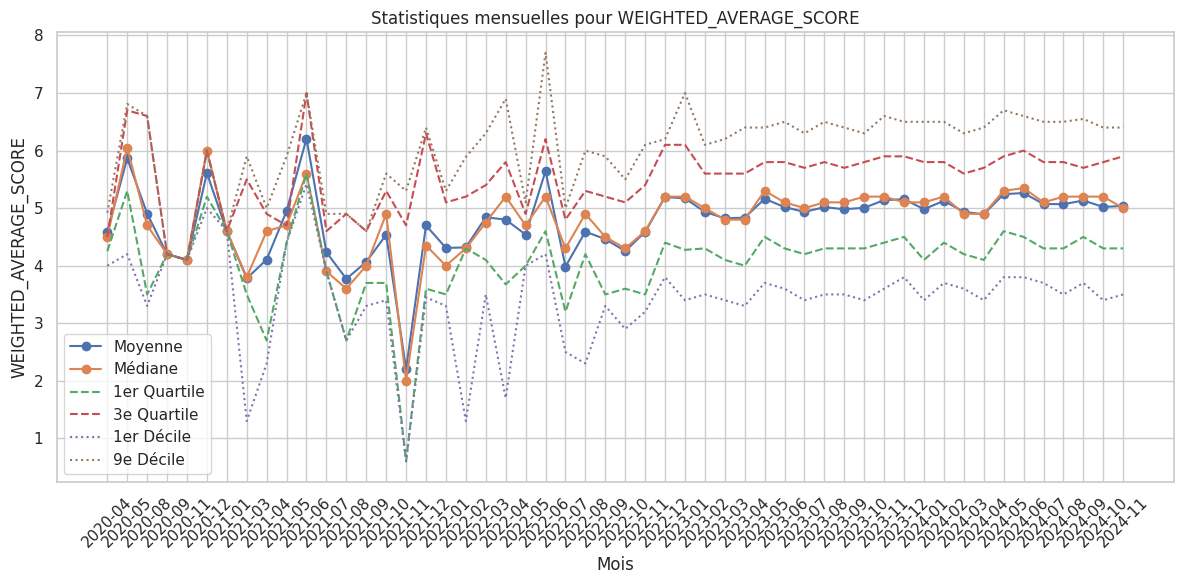

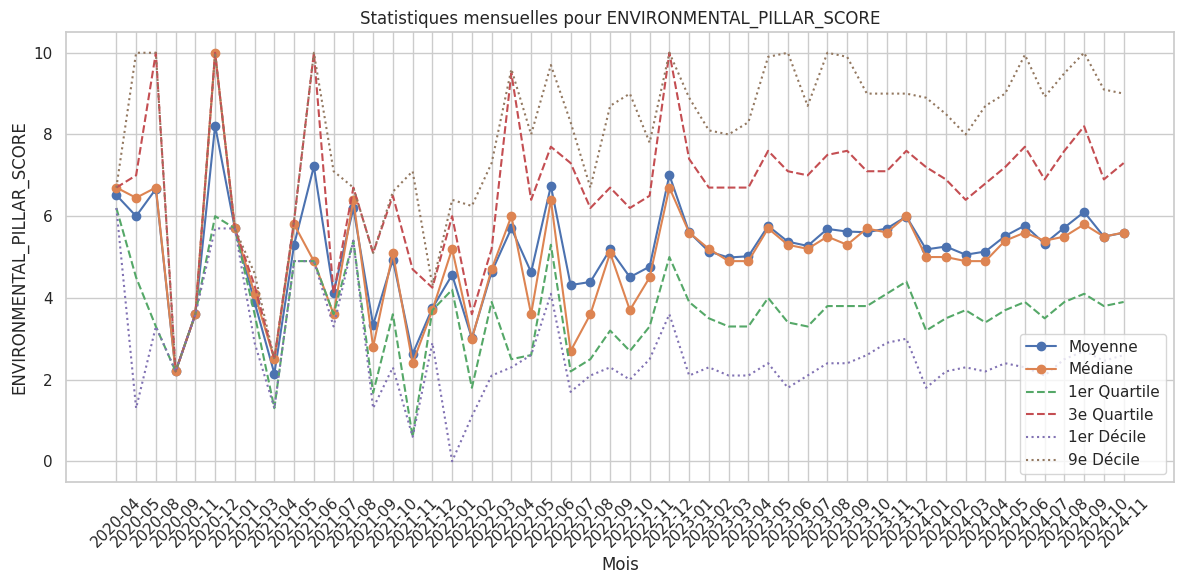

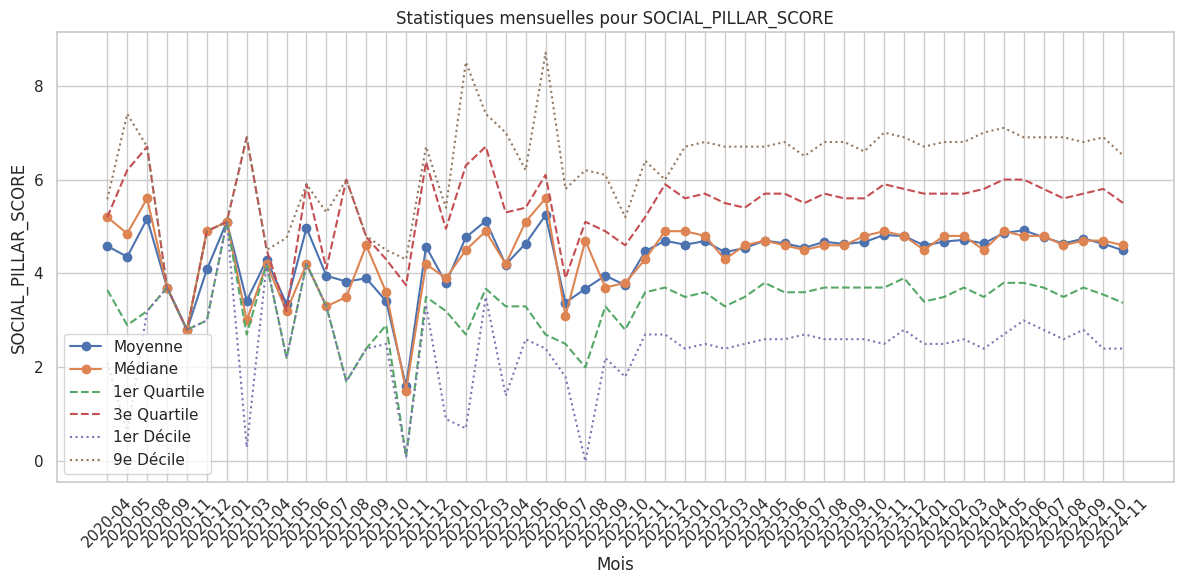

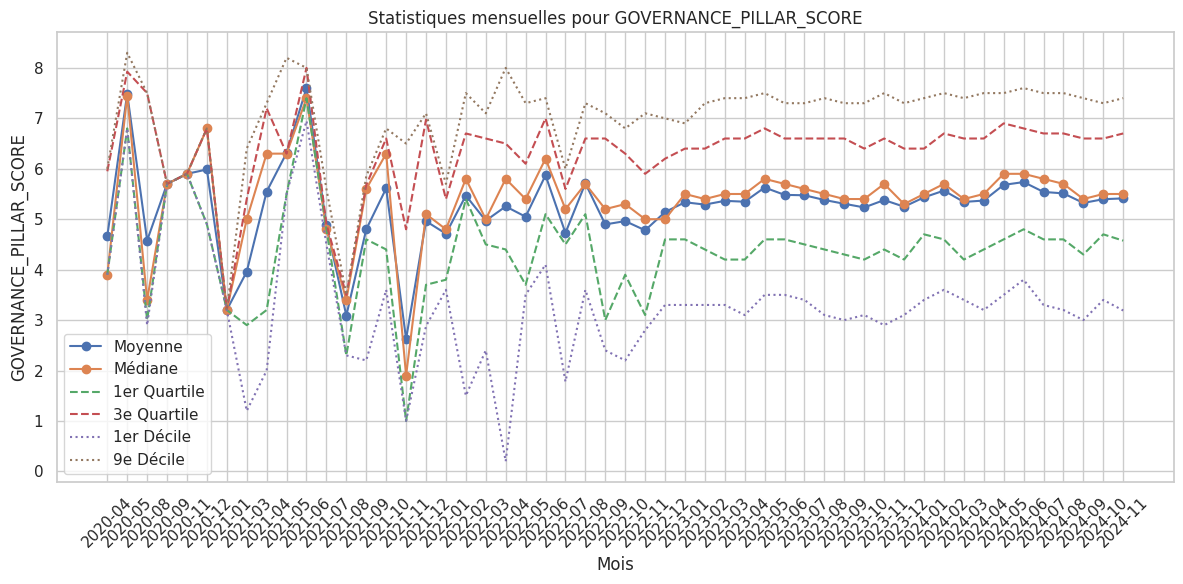

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le fichier Excel
df = pd.read_excel("/home/onyxia/work/Statapp_Valuco/feuilles_separees/ValueCo V2_ESG2024.xlsx")

# Convertir la date en datetime si ce n'est pas déjà le cas
df["IVA_RATING_DATE"] = pd.to_datetime(df["IVA_RATING_DATE"])

# Extraire année et mois pour regrouper par mois
df["mois"] = df["IVA_RATING_DATE"].dt.to_period("M").astype(str)

# Liste des scores à tracer
scores = [
    "WEIGHTED_AVERAGE_SCORE",
    "ENVIRONMENTAL_PILLAR_SCORE",
    "SOCIAL_PILLAR_SCORE",
    "GOVERNANCE_PILLAR_SCORE"
]



# Configuration visuelle
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Trier les périodes dans l'ordre chronologique
mois_order = sorted(df["mois"].unique())

# Générer un graphique pour chaque score
for var in scores:
    stats = df.groupby("mois")[var].agg([
        ("moyenne", "mean"),
        ("mediane", "median"),
        ("Q1", lambda x: x.quantile(0.25)),
        ("Q3", lambda x: x.quantile(0.75)),
        ("D1", lambda x: x.quantile(0.10)),
        ("D9", lambda x: x.quantile(0.90))
    ]).reindex(mois_order)

    # Tracer
    plt.figure()
    plt.plot(stats.index, stats["moyenne"], label="Moyenne", marker='o')
    plt.plot(stats.index, stats["mediane"], label="Médiane", marker='o')
    plt.plot(stats.index, stats["Q1"], label="1er Quartile", linestyle="--")
    plt.plot(stats.index, stats["Q3"], label="3e Quartile", linestyle="--")
    plt.plot(stats.index, stats["D1"], label="1er Décile", linestyle=":")
    plt.plot(stats.index, stats["D9"], label="9e Décile", linestyle=":")

    plt.title(f"Statistiques mensuelles pour {var}")
    plt.xlabel("Mois")
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{var}_mensuel_stats.png")
    plt.show()